In [1]:
# Import libraries
import numpy as np
import pandas as pd
import string
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Input parameters
export_feedback_table = False
inputfile_sssummary  = 'output/studentsummary2_20240222.csv'
inputfile_assignment = 'rawdata/assignment_20240222.csv'
inputfile_feedback   = 'rawdata/feedback_20240222.csv'
outputfile_feedback  = 'output/feedback_pretest_20240222.xlsx'

In [3]:
# Import raw data and converting 'created' to datetime
df_sssummary  = pd.read_csv(inputfile_sssummary, index_col=0)
df_assignment = pd.read_csv(inputfile_assignment, index_col=0)
df_feedback   = pd.read_csv(inputfile_feedback, index_col=0)
df_sssummary['1st_created'] = pd.to_datetime(df_sssummary['1st_created'])
df_assignment['created']    = pd.to_datetime(df_assignment['created'])
df_feedback['created']      = pd.to_datetime(df_feedback['created'])

In [4]:
# Preview summary of students
df_sssummary

,anonym,1st_assignment_id,1st_instance_id,1st_created,1st_finished,2nd_assignment_id,2nd_instance_id,2nd_created,2nd_finished
0,AS23S0335,9cc8536e-35ac-4874-807d-9da3d47a4a89,SLF6A,2023-11-02 08:53:20.875,2023-11-02 09:25:30.675000,45209efe-cda7-480f-8984-1a3f780c840d,MYF6A,2023-12-14 07:11:24.502000,2023-12-14 07:34:11.516000
1,AS23S0336,773fac84-9653-4706-94f2-555506fc3c33,MLF6A,2023-11-02 08:58:00.657,2023-11-02 09:22:16.908000,d2fa8b28-d4d6-4c19-82aa-da16bd7a5788,SYF6A,2023-12-14 07:05:41.840000,2023-12-14 07:35:03.174000
2,AS23S0338,7bc2eab6-f284-42ae-b22b-5edfb37dbe8b,SPF6A,2023-11-02 08:54:09.316,2023-11-02 09:38:22.077000,af7ce587-f8ad-4459-93b0-57fd57d9f51a,MTF6A,2023-12-14 07:08:11.195000,2023-12-14 07:51:40.348000
3,AS23S0339,7448ecde-72d7-4a88-817f-ed4a726879b9,MPF6A,2023-11-02 08:58:04.547,2023-11-02 09:22:15.866000,10119783-d851-4169-a3cd-cd90e31b3c4d,SYF6A,2023-12-14 07:11:25.845000,2023-12-14 07:50:46.121000
4,AS23S0340,d47c0ae8-7835-460b-95fa-c7628e5b2a6f,SLF6A,2023-11-02 08:54:17.666,2023-11-02 09:38:28.370000,4ba95ff5-dce4-4fb3-9ede-5f8b1e85aaa3,MTF6A,2023-12-14 07:10:13.541000,2023-12-14 07:48:41.943000
...,...,...,...,...,...,...,...,...,...
164,KS23S7504,1daffd53-64f0-423f-a501-7aff26dd1de0,SLU5A,2023-11-03 07:28:42.896,2023-11-03 07:50:57.367000,NaN,NaN,NaN,NaN
165,KS23S7505,88363ab5-e685-47fb-a086-47298f636902,SLU5A,2023-11-03 07:29:29.346,NaN,NaN,NaN,NaN,NaN
166,KS23S7506,0041f35d-0cbd-4efe-82c4-b62a72aec1d4,MLU5A,2023-11-03 07:28:27.723,2023-11-03 08:00:36.275000,NaN,NaN,NaN,NaN
167,KS23S7507,43da8763-68ef-4ed9-8735-162eeceedf07,SPU5A,2023-11-03 07:28:50.540,2023-11-03 08:00:26.558000,NaN,NaN,NaN,NaN


### Feedback Data Preprocessing

In [5]:
# Add the 'time_elapsed' column to df_feedback

def calculate_time_difference(row, df_a):
    sid = row['assignment_id'] 
    action_time = row['created']
    # Check if student_id exists in df_a
    if sid in df_a.index:
        starting_time = df_a.at[sid, 'created']
        return (action_time - starting_time).total_seconds()
    else:
        return None  # or some other default value

df_feedback['time_elapsed'] = df_feedback.apply(lambda row: calculate_time_difference(row, df_assignment), axis=1)

In [6]:
# Remove abnormality on time elapsed, which should be less than 1 hour
df_feedback = df_feedback[df_feedback['time_elapsed'] <= 3600]

In [7]:
# Sort the DataFrame by 'assignment_id' and 'created' to ensure the order
df_feedback = df_feedback.sort_values(by=['assignment_id', 'created'])

# Add a new column 'sequence' which enumerates each student's rows starting from 1
df_feedback['count'] = df_feedback.groupby('assignment_id').cumcount() + 1

In [8]:
# Use 911e7cad-2261-4755-825d-dd734c8bfaa1 for testing
# Find the starting time of the student
print(df_assignment.loc['911e7cad-2261-4755-825d-dd734c8bfaa1','created'])
df_feedback[df_feedback['assignment_id']=='911e7cad-2261-4755-825d-dd734c8bfaa1']
df_feedback[df_feedback['assignment_id']=='8fe8bdd5-1bfe-4c12-873b-810b4dc9de57']


2023-11-02 07:24:41.273000


,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
2ebbe296-d612-4bca-9cdf-73ca5c3087c9,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Pääkohtien valinnan tarkoituksena on löytää te...,"{""text_id"": 302, ""feedback_code"": 0, ""details""...",2023-11-03 08:28:28.429,256.887,1
a5b2ff07-e9ee-4e7a-b25b-3d580b1b9fce,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Erinomaista! Olet valinnut tästä tekstistä 4 p...,"{""text_id"": 302, ""feedback_code"": 9, ""details""...",2023-11-03 08:30:59.290,407.748,2
55217017-2e70-4c34-8e65-2a1716221582,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Mahtava yritys! Olet valinnut tästä tekstistä ...,"{""text_id"": 301, ""feedback_code"": 3, ""details""...",2023-11-03 08:36:43.661,752.119,3
63a09dac-1742-48a4-baaa-e30df3f5fafa,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Huikeaa! Olet valinnut tästä tekstistä 5 pääko...,"{""text_id"": 301, ""feedback_code"": 9, ""details""...",2023-11-03 08:37:19.568,788.026,4
57b62cf5-752b-4560-8360-65a2d2d5ea7c,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvin menee! Olet valinnut 5 pääkohtaa tästä t...,"{""text_id"": 308, ""feedback_code"": 1, ""details""...",2023-11-03 08:43:01.230,1129.688,5
b886bfcd-5a0e-494d-9f36-369619e0d9fe,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Loistava yritys! Olet valinnut 6 pääkohtaa täs...,"{""text_id"": 308, ""feedback_code"": 1, ""details""...",2023-11-03 08:43:39.534,1167.992,6
1ba6aa30-22c3-4c68-8869-b3e2dd213951,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvä edistys! Olet valinnut kaksi tai useamman...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:47:17.302,1385.760,7
11c8a408-a8c6-48dc-b3bc-34283271b1e4,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hyvin menee! Olet valinnut kaksi tai useamman ...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:47:48.391,1416.849,8
e1a05635-b054-4410-ae1c-7a5629571449,8fe8bdd5-1bfe-4c12-873b-810b4dc9de57,snippet_micro,NaN,Hienosti yritetty! Olet valinnut kaksi tai use...,"{""text_id"": 303, ""feedback_code"": 5, ""details""...",2023-11-03 08:48:35.470,1463.928,9


In [9]:
df_feedback.sort_values('time_elapsed')


,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
d046c672-3a8d-426b-84e6-153ac6a5667b,036546ed-faa3-4ade-ba37-2c74e6a0dfff,search,NaN,Hienoa! Löysit 2 tehtävään sopivaa sivua Tarvi...,"{""0"":{""assignment_id"":""036546ed-faa3-4ade-ba37...",2023-12-08 08:10:33.023,48.481,1
ef110b2e-3dc5-42a7-bbd3-d85cc7ab9de0,036546ed-faa3-4ade-ba37-2c74e6a0dfff,search,NaN,Hienoa! Löysit 2 tehtävään sopivaa sivua Tarvi...,"{""0"":{""assignment_id"":""036546ed-faa3-4ade-ba37...",2023-12-08 08:10:33.646,49.104,2
db357d25-dbbf-4ef6-affd-04dff633cb51,7448ecde-72d7-4a88-817f-ed4a726879b9,search,NaN,Viimeisin hakusi löysi 0 sopivaa sivua. Sinul...,"{""0"":{""assignment_id"":""7448ecde-72d7-4a88-817f...",2023-11-02 08:59:00.020,55.473,1
94411d8d-177a-4d74-b128-8fdcc802aa69,d0637fb0-4963-48c7-91f8-fa4b83d6e1e3,search,NaN,Haun tarkoitus on löytää tehtävän kannalta hyö...,"{""0"":{""assignment_id"":""d0637fb0-4963-48c7-91f8...",2023-11-03 07:21:51.080,57.130,1
0a42b824-8012-4f39-9d42-0cf962c92246,81c6d13c-095e-4dde-8689-c68a99df7f07,search,NaN,Haun tarkoitus on löytää tehtävän kannalta hyö...,"{""0"":{""assignment_id"":""81c6d13c-095e-4dde-8689...",2023-12-12 07:16:21.388,59.772,1
...,...,...,...,...,...,...,...,...
24d90552-f953-4b42-921e-4b62247b3222,e63a80de-941f-4b14-91a4-657ec8ada29b,snippet_micro,NaN,Hyvä yritys! Olet valinnut 1 pääkohdan tästä t...,"{""text_id"": 337, ""feedback_code"": 1, ""details""...",2023-11-06 08:03:48.789,2220.384,3
950bfc94-a485-4afc-b336-10f3a9c8e9ce,7c1355f0-2161-44db-b79c-5049524fc16f,snippet_micro,NaN,Hienosti yritetty! Olet valinnut 2 pääkohtaa t...,"{""text_id"": 349, ""feedback_code"": 1, ""details""...",2023-11-02 09:33:49.658,2248.365,4
25fd4a54-f0dd-4e8a-b68b-a328e76ee378,80647cda-ff00-4e36-9944-6d5ccd7aebc5,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""80647cda-ff00-4e36-9944...",2023-12-14 09:45:40.853,2298.297,7


In [10]:
# Export to Excel
if (export_feedback_table):
    # Convert 'created' column to timezone-naive datetimes as Excel does not support timezone
    df_feedback_export = df_feedback.copy()
    df_feedback_export['created'] = df_feedback_export['created'].dt.tz_localize(None)
    df_feedback_export.to_excel(outputfile_feedback)

## Analysis with Target Group(s)

In [11]:
# Define the target groups and tests and get the assignment_id for analysis
list_group = ['Intervention','Control','Both']
list_test = ['Pre','Post','Both']
list_task = ['Metsa','Suo','Both']
list_form = ['Long','Short','Both']

def get_target_df(df, group='Both', filter_bothtest=True, test='Both'):
    # Choose group
    if group == 'Intervention':
        df_filtered = df[df['anonym'].str.startswith("A")]
    elif group == 'Control':
        df_filtered = df[df['anonym'].str.startswith("K")]
    else:  # Both groups
        df_filtered = df

    # Filter rows based on NA values in assignments (participated in both tests)
    if filter_bothtest:
        df_filtered = df_filtered.dropna(subset=['1st_assignment_id', '2nd_assignment_id'])
    else:
        df_filtered = df_filtered[df_filtered[['1st_assignment_id', '2nd_assignment_id']].isna().any(axis=1)]

    # Choose assignments
    if test == 'Pre':
        target_assid = df_filtered['1st_assignment_id'].tolist()
    elif test == 'Post':
        target_assid = df_filtered['2nd_assignment_id'].tolist()
    else:  # Both tests
        target_assid = df_filtered['1st_assignment_id'].tolist() + df_filtered['2nd_assignment_id'].tolist()

    return df_filtered, target_assid

# Example
df_target, target_assid = get_target_df(df_sssummary, group='Control', filter_bothtest=True, test='Pre')
print(len(target_assid))
df_target

48


,anonym,1st_assignment_id,1st_instance_id,1st_created,1st_finished,2nd_assignment_id,2nd_instance_id,2nd_created,2nd_finished
97,KS23S0458,1364e8df-aea1-4a1c-8c77-c84d836b9291,SLT5A,2023-11-07 07:27:06.627,2023-11-07 08:10:00.707000,f3e7e09d-a3c3-4581-a92b-47435cab10a5,MTT5A,2023-12-12 07:12:34.094000,NaN
98,KS23S0459,52d8ea0c-1328-4b97-abde-13c0ffcafa0f,SPT5A,2023-11-07 07:24:34.413,2023-11-07 07:53:18.778000,7f1684cd-5766-4acd-b1ad-b9bb95b691c7,MYT5A,2023-12-12 07:12:11.062000,2023-12-12 07:31:05.781000
99,KS23S0461,9a8e2182-fa0a-4c49-8115-fb8870446a6f,SPT5A,2023-11-07 07:27:12.516,2023-11-07 07:47:39.519000,a0365be0-91e9-466c-86c0-78a6a836a298,MYT5A,2023-12-12 07:11:59.693000,2023-12-12 07:45:07.335000
100,KS23S0462,2cef994b-20d3-4dfe-a601-ff55229ac2a2,MPT5A,2023-11-07 07:24:50.642,2023-11-07 07:55:14.600000,45514582-ec57-45da-b355-5adf5c6a42e5,STT5A,2023-12-12 07:14:17.475000,2023-12-12 07:40:12.416000
101,KS23S0463,e7cd2cba-e608-4560-a27d-69ad076d6b0d,MLT5A,2023-11-07 07:24:17.712,2023-11-07 08:00:31.563000,9c7ed7ab-982c-4406-b88a-058df3586f0c,SYT5A,2023-12-12 07:09:38.889000,2023-12-12 07:49:33.622000
102,KS23S0464,73716848-19af-4f1d-8408-d38a9eec1195,SPT5A,2023-11-07 07:24:48.003,2023-11-07 08:04:10.844000,e4e4fc6d-d9d2-4858-b334-affe9de5e0bb,MYT5A,2023-12-12 07:13:50.218000,2023-12-12 07:51:37.691000
103,KS23S0465,b0d98a08-8e17-44da-b14e-c4f1838db509,MPT5A,2023-11-07 07:27:03.846,2023-11-07 07:45:12.707000,57fe206e-323e-4856-a7be-de1aaedd7544,SYT5A,2023-12-12 07:12:45.045000,2023-12-12 07:36:17.878000
104,KS23S0466,8b7e9917-b5f4-441c-b190-d859c0c63548,MLT5A,2023-11-07 07:23:15.081,2023-11-07 08:01:12.544000,17d0d44d-f230-402e-8504-369dec2e5d12,SYT5A,2023-12-12 07:10:54.970000,2023-12-12 07:34:00.015000
105,KS23S0467,b3085707-1da8-4eb3-9cce-ffd64b7078f4,MPT5A,2023-11-07 07:23:18.205,2023-11-07 07:59:24.702000,38b0ac4a-0e97-4dcf-9d0d-56ad8672619e,SYT5A,2023-12-12 07:12:30.989000,2023-12-12 07:37:30.734000
106,KS23S0468,82371658-9ebd-4824-aa80-937d7bcb2d3a,MLT5A,2023-11-07 07:25:10.084,2023-11-07 08:03:21.014000,2f96f63a-a6b3-408b-a56c-c79fc435efdd,STT5A,2023-12-12 07:13:42.002000,2023-12-12 07:48:08.527000


In [12]:
# Filtered the feedback df with the target assignment_id
df_feedback_filtered = df_feedback[df_feedback['assignment_id'].isin(target_assid)]
df_feedback_filtered

,assignment_id,phase,type_id,feedback_text,details,created,time_elapsed,count
action_id,,,,,,,,
f3b43013-f610-4ef6-af4c-1c15742addc1,07fb2b8e-7108-4404-a70d-0e271a808471,snippet_micro,NaN,Pääkohtien valinnan tarkoituksena on löytää te...,"{""text_id"": 309, ""feedback_code"": 0, ""details""...",2023-11-07 07:34:32.494,569.394,1
21f82f5d-9914-4705-84fa-916940468dc3,0a440a85-9330-4156-9b1a-3ecd226abab1,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""0a440a85-9330-4156-9b1a...",2023-11-03 08:43:17.841,1342.513,1
38af4f1c-a9db-4bf7-b3bd-0ad2d3caa4f6,0a440a85-9330-4156-9b1a-3ecd226abab1,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""0a440a85-9330-4156-9b1a...",2023-11-03 08:44:43.558,1428.230,2
fcba15a3-90b3-4912-a742-af1b297c17f0,125fba01-6efb-4aec-98ce-a66b9a47e919,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""125fba01-6efb-4aec-98ce...",2023-11-06 10:11:54.615,755.047,1
95d6fd62-7479-42db-97b5-e0f8cafaf272,125fba01-6efb-4aec-98ce-a66b9a47e919,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""125fba01-6efb-4aec-98ce...",2023-11-06 10:25:29.186,1569.618,2
...,...,...,...,...,...,...,...,...
24d90552-f953-4b42-921e-4b62247b3222,e63a80de-941f-4b14-91a4-657ec8ada29b,snippet_micro,NaN,Hyvä yritys! Olet valinnut 1 pääkohdan tästä t...,"{""text_id"": 337, ""feedback_code"": 1, ""details""...",2023-11-06 08:03:48.789,2220.384,3
426a9778-e2c2-48f5-b0db-f6e313f93005,e7cd2cba-e608-4560-a27d-69ad076d6b0d,search,NaN,Hyvä! Olet vieraillut 2 tehtävään sopivalla si...,"{""0"":{""assignment_id"":""e7cd2cba-e608-4560-a27d...",2023-11-07 07:42:38.550,1100.838,1
176d9e84-17ce-48d6-aa6c-1ebfc4006f1a,efc6ebae-db7f-45a0-9be0-61d9329db88b,snippet_micro,NaN,Pääkohtien valinnan tarkoituksena on löytää te...,"{""text_id"": 310, ""feedback_code"": 0, ""details""...",2023-11-03 08:25:35.056,374.209,1


In [13]:
# Check the number of each type of feedback
df_feedback_filtered.groupby('phase').describe()

type_id                              time_elapsed               \
                count mean std min 25% 50% 75% max        count         mean   
phase                                                                          
search            0.0  NaN NaN NaN NaN NaN NaN NaN         65.0   843.870877   
snippet_micro     0.0  NaN NaN NaN NaN NaN NaN NaN         62.0  1047.513677   

               ...                     count                               \
               ...       75%       max count      mean      std  min  25%   
phase          ...                                                          
search         ...  1109.772  1906.985  65.0  4.138462  3.71600  1.0  1.0   
snippet_micro  ...  1285.633  2220.384  62.0  2.709677  1.82323  1.0  1.0   

                               
               50%  75%   max  
phase                          
search         2.0  6.0  15.0  
snippet_micro  2.0  3.0   8.0  

[2 rows x 24 columns]

In [14]:
# Group by 'count' and calculate the mean of 'time_elapsed' for each group
average_time_elapsed_per_count = df_feedback_filtered.groupby('count')['time_elapsed'].describe()

# Display the average time elapsed for counts from 1 to 15
average_time_elapsed_per_count.loc[1:15]

,count,mean,std,min,25%,50%,75%,max
count,,,,,,,,
1,39.0,630.345564,434.963012,63.805,303.49200,505.5710,952.65450,1851.625
2,27.0,969.246778,492.054476,157.485,615.64950,968.7860,1189.39900,2174.635
3,19.0,1069.435000,499.114992,219.035,775.07750,1137.6650,1252.48000,2220.384
4,12.0,1132.348333,523.575474,306.003,714.63450,1165.0640,1386.86025,2096.010
5,7.0,1065.361857,464.283560,569.010,723.26800,782.6080,1517.19900,1624.981
6,5.0,1157.266600,405.470111,887.201,916.93500,974.8330,1147.56400,1859.800
7,4.0,1272.022500,476.995636,906.575,1010.94125,1105.9580,1367.03925,1969.599
8,4.0,1384.265000,465.873178,912.862,1111.33525,1310.7010,1583.63075,2002.796
9,2.0,1221.083500,427.240281,918.979,1070.03125,1221.0835,1372.13575,1523.188


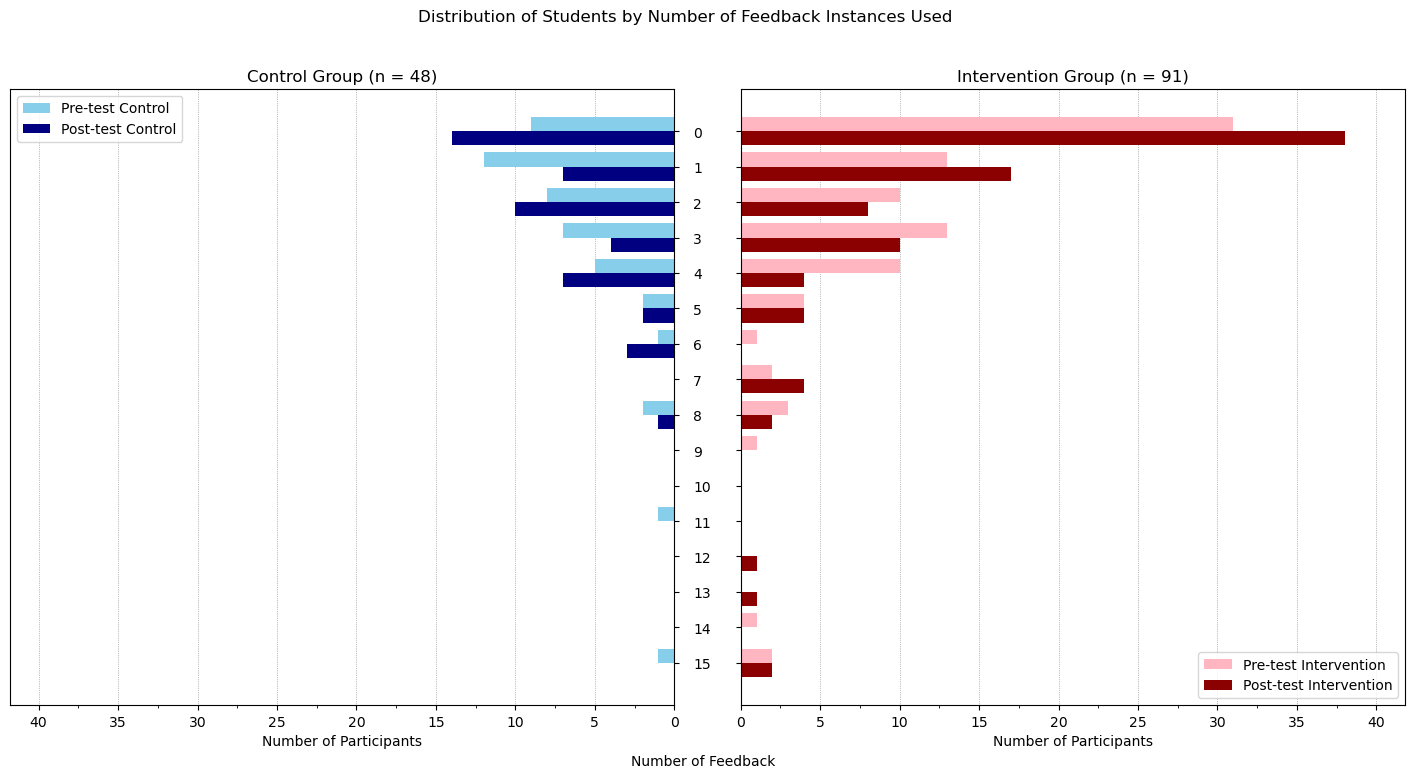

In [15]:
# New data
'''
data = {
    'Feedback Used': ['15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1'],
    'Pre-test Control': [1,1,1,1,2,2,2,4,4,5,7,12,19,27,39],
    'Post-test Control': [0,0,0,0,0,0,0,1,1,4,6,13,17,27,34],
    'Pre-test Intervention': [2,3,3,3,3,3,4,7,9,10,14,24,37,47,60],
    'Post-test Intervention': [2,2,3,4,4,4,4,6,10,10,14,18,28,36,53]
}
'''
data = {
    'Feedback Used': ['15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0'],
    'Pre-test Control': [1,0,0,0,1,0,0,2,0,1,2,5,7,8,12,9],
    'Post-test Control': [0,0,0,0,0,0,0,1,0,3,2,7,4,10,7,14],
    'Pre-test Intervention': [2,1,0,0,0,0,1,3,2,1,4,10,13,10,13,31],
    'Post-test Intervention': [2,0,1,1,0,0,0,2,4,0,4,4,10,8,17,38]
}
df = pd.DataFrame(data)

# Create the subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Set up minor ticks on the x-axis using a locator
locator = ticker.AutoMinorLocator(2)  # This will add one minor tick between the major ticks
ax1.xaxis.set_minor_locator(locator)
ax2.xaxis.set_minor_locator(locator)

# Enable vertical grid lines for minor ticks on both subplots
# Customize the grid's appearance as desired
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')
ax2.grid(which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')


# Set the positions of the bars on the x-axis
indices = np.arange(len(df['Feedback Used']))
width = 0.4  # the width of the bars has been adjusted to accommodate four bars

# Plot bars for Control group
ax1.barh(indices + width/2, df['Pre-test Control'], width, label='Pre-test Control', color='skyblue')
ax1.barh(indices - width/2, df['Post-test Control'], width, label='Post-test Control', color='navy')

# Plot bars for Intervention group
ax2.barh(indices + width/2, df['Pre-test Intervention'], width, label='Pre-test Intervention', color='lightpink')
ax2.barh(indices - width/2, df['Post-test Intervention'], width, label='Post-test Intervention', color='darkred')

# Invert the x-axis of the Control subplot for a mirrored effect
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(axis='y', which='major', pad=10)

# Set titles
ax1.set(title='Control Group (n = 48)')
ax2.set(title='Intervention Group (n = 91)')

# Calculate the maximum value across all datasets and add some padding for visual aesthetics
max_value = max(df['Pre-test Control'].max(), df['Post-test Control'].max(), 
                df['Pre-test Intervention'].max(), df['Post-test Intervention'].max())
padding = max_value * 0.1
max_limit = max_value + padding

# Set the same x-axis limits for both subplots, with padding
ax1.set_xlim(max_limit, 0)  # Inverted axis for ax1
ax2.set_xlim(0, max_limit)

# Set y-ticks to be in the middle of the grouped bars
ax2.set_yticks(indices)
ax2.set_yticklabels(df['Feedback Used'])

# Set y-axis label as text
fig.text(0.51, 0.04, 'Number of Feedback', ha='center', va='center')


# Set x-axis labels
ax1.set_xlabel('Number of Participants')
ax2.set_xlabel('Number of Participants')

# Add legends
ax1.legend()
ax2.legend()

# Adjust layout
plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between the two subplots to prevent overlap

# Set the figure title
fig.suptitle('Distribution of Students by Number of Feedback Instances Used')

# Show the plot
plt.show()


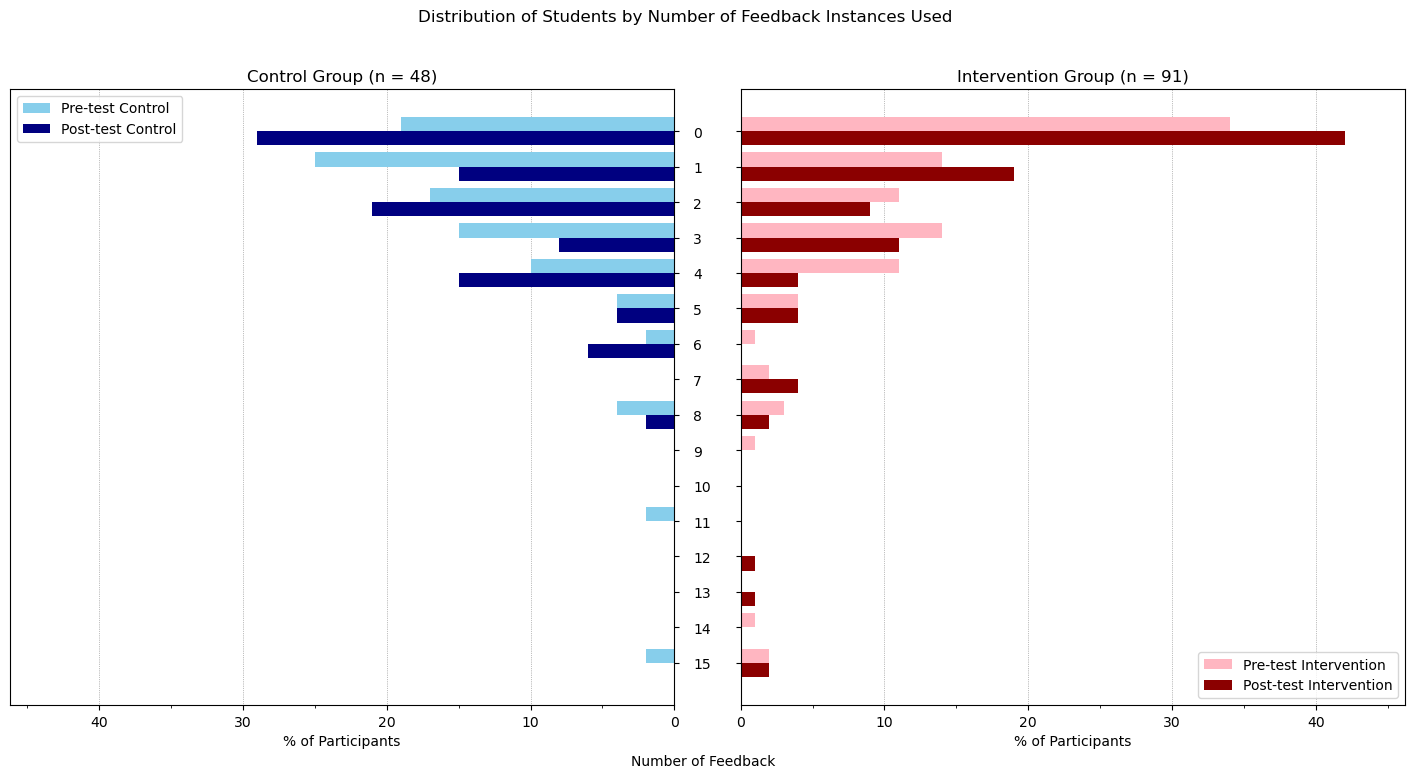

In [16]:
# New data
'''
data = {
    'Feedback Used': ['15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0'],
    'Pre-test Control': [1,0,0,0,1,0,0,2,0,1,2,5,7,8,12,9],
    'Post-test Control': [0,0,0,0,0,0,0,1,0,3,2,7,4,10,7,14],
    'Pre-test Intervention': [2,1,0,0,0,0,1,3,2,1,4,10,13,10,13,31],
    'Post-test Intervention': [2,0,1,1,0,0,0,2,4,0,4,4,10,8,17,38]
}
'''
data = {
    'Feedback Used': ['15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0'],
    'Pre-test Control': [2, 0, 0, 0, 2, 0, 0, 4, 0, 2, 4, 10, 15, 17, 25, 19],
    'Post-test Control': [0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 4, 15, 8, 21, 15, 29],
    'Pre-test Intervention': [2, 1, 0, 0, 0, 0, 1, 3, 2, 1, 4, 11, 14, 11, 14, 34],
    'Post-test Intervention': [2, 0, 1, 1, 0, 0, 0, 2, 4, 0, 4, 4, 11, 9, 19, 42]
}

df = pd.DataFrame(data)

# Create the subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Set up minor ticks on the x-axis using a locator
locator = ticker.AutoMinorLocator(2)  # This will add one minor tick between the major ticks
ax1.xaxis.set_minor_locator(locator)
ax2.xaxis.set_minor_locator(locator)

# Enable vertical grid lines for minor ticks on both subplots
# Customize the grid's appearance as desired
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')
ax2.grid(which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')


# Set the positions of the bars on the x-axis
indices = np.arange(len(df['Feedback Used']))
width = 0.4  # the width of the bars has been adjusted to accommodate four bars

# Plot bars for Control group
ax1.barh(indices + width/2, df['Pre-test Control'], width, label='Pre-test Control', color='skyblue')
ax1.barh(indices - width/2, df['Post-test Control'], width, label='Post-test Control', color='navy')

# Plot bars for Intervention group
ax2.barh(indices + width/2, df['Pre-test Intervention'], width, label='Pre-test Intervention', color='lightpink')
ax2.barh(indices - width/2, df['Post-test Intervention'], width, label='Post-test Intervention', color='darkred')

# Invert the x-axis of the Control subplot for a mirrored effect
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(axis='y', which='major', pad=10)

# Set titles
ax1.set(title='Control Group (n = 48)')
ax2.set(title='Intervention Group (n = 91)')

# Calculate the maximum value across all datasets and add some padding for visual aesthetics
max_value = max(df['Pre-test Control'].max(), df['Post-test Control'].max(), 
                df['Pre-test Intervention'].max(), df['Post-test Intervention'].max())
padding = max_value * 0.1
max_limit = max_value + padding

# Set the same x-axis limits for both subplots, with padding
ax1.set_xlim(max_limit, 0)  # Inverted axis for ax1
ax2.set_xlim(0, max_limit)

# Set y-ticks to be in the middle of the grouped bars
ax2.set_yticks(indices)
ax2.set_yticklabels(df['Feedback Used'])

# Set y-axis label as text
fig.text(0.51, 0.04, 'Number of Feedback', ha='center', va='center')


# Set x-axis labels
ax1.set_xlabel('% of Participants')
ax2.set_xlabel('% of Participants')

# Add legends
ax1.legend()
ax2.legend()

# Adjust layout
plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between the two subplots to prevent overlap

# Set the figure title
fig.suptitle('Distribution of Students by Number of Feedback Instances Used')

# Show the plot
plt.show()


In [17]:
'''
data = {
    'Feedback Used': ['15', '14', '13', '12', '11', '10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0'],
    'Pre-test Control': [2, 0, 0, 0, 2, 0, 0, 4, 0, 2, 4, 10, 15, 17, 25, 19],
    'Post-test Control': [0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 4, 15, 8, 21, 15, 29],
    'Pre-test Intervention': [2, 1, 0, 0, 0, 0, 1, 3, 2, 1, 4, 11, 14, 11, 14, 34],
    'Post-test Intervention': [2, 0, 1, 1, 0, 0, 0, 2, 4, 0, 4, 4, 11, 9, 19, 42]
}
'''

list1 = [2,0,1,1,0,0,0,2,4,0,4,4,10,8,17,38]

# Divide each element in the list by 2
result_list = [round(x * 100 / 91) for x in list1]

result_list

[2, 0, 1, 1, 0, 0, 0, 2, 4, 0, 4, 4, 11, 9, 19, 42]